In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [55]:
from itertools import combinations
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error

# 1. Data Loading

In [13]:
train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
print("Shape of training dataset: ", train_df.shape)

Shape of training dataset:  (1460, 81)


In [14]:
X, y = train_df[train_df.columns[:-1]], train_df['SalePrice']

In [61]:
print(X.head(10))

   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.235294     0.150685  0.033420     0.666667        0.500   0.949275   
1    0.000000     0.202055  0.038795     0.555556        0.875   0.753623   
2    0.235294     0.160959  0.046507     0.666667        0.500   0.934783   
3    0.294118     0.133562  0.038561     0.666667        0.500   0.311594   
4    0.235294     0.215753  0.060576     0.777778        0.500   0.927536   
5    0.176471     0.219178  0.059899     0.444444        0.500   0.876812   
6    0.000000     0.184932  0.041057     0.777778        0.500   0.956522   
7    0.235294     0.164384  0.042450     0.666667        0.625   0.731884   
8    0.176471     0.102740  0.022529     0.666667        0.500   0.427536   
9    1.000000     0.099315  0.028605     0.444444        0.625   0.485507   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  \
0      0.883333     0.12250    0.125089     0.00000  ...   
1      0.433333     0.00000    0

# 2. Data Cleaning

<h2>2.1 Encode Categorical Values</h2>

In [15]:
# Check the number of unique categories in each category
# Decide which categorical variables need to be encoded
for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(
            col_name=col_name, unique_cat=unique_cat))

Feature 'MSZoning' has 5 unique categories
Feature 'Street' has 2 unique categories
Feature 'Alley' has 3 unique categories
Feature 'LotShape' has 4 unique categories
Feature 'LandContour' has 4 unique categories
Feature 'Utilities' has 2 unique categories
Feature 'LotConfig' has 5 unique categories
Feature 'LandSlope' has 3 unique categories
Feature 'Neighborhood' has 25 unique categories
Feature 'Condition1' has 9 unique categories
Feature 'Condition2' has 8 unique categories
Feature 'BldgType' has 5 unique categories
Feature 'HouseStyle' has 8 unique categories
Feature 'RoofStyle' has 6 unique categories
Feature 'RoofMatl' has 8 unique categories
Feature 'Exterior1st' has 15 unique categories
Feature 'Exterior2nd' has 16 unique categories
Feature 'MasVnrType' has 5 unique categories
Feature 'ExterQual' has 4 unique categories
Feature 'ExterCond' has 5 unique categories
Feature 'Foundation' has 6 unique categories
Feature 'BsmtQual' has 5 unique categories
Feature 'BsmtCond' has 5 un

In [16]:
# Get names of columns to encode (all columns in this case)
cols_to_encode = []
for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        cols_to_encode.append(col_name)

In [17]:
# Function to create ordinal encoding for all categorical colums
# This function will be used on the test data as well
def create_ordinal_encoding(df, dummy_list):
    for x in dummy_list:
        col_name_code = x + '_code'
        
        # Replace missing values in categorical column with mode
        # Need to do this step for ordinal encoding
        df[x].fillna(df[x].value_counts().index[0], inplace=True)
        
        ord_enc = OrdinalEncoder()
        df[col_name_code] = ord_enc.fit_transform(df[[x]])
        df = df.drop(x, 1)
        
    return df

In [18]:
X = create_ordinal_encoding(X, cols_to_encode)

In [19]:
print("Shape of training dataset: ", X.shape)

Shape of training dataset:  (1460, 80)


<h2>2.2 Handle Missing Values</h2>

Since all the columns have been encoded, now the data in training dataset is completely numerical.

In [22]:
# Check to see if there is missing data in the dataset
X.isnull().sum().sort_values(ascending=False).head()

LotFrontage           259
GarageYrBlt            81
MasVnrArea              8
SaleCondition_code      0
OpenPorchSF             0
dtype: int64

In [21]:
# Function to replace missing value with median
# This function will be used on the test data as well
def impute_missing_values(df):
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(df)
    df = pd.DataFrame(data=imp.transform(df), columns=df.columns)
    return df

In [23]:
X = impute_missing_values(X)

In [24]:
# Now check again to see if you still have missing data
X.isnull().sum().sort_values(ascending=False).head()

SaleCondition_code    0
SaleType_code         0
BedroomAbvGr          0
KitchenAbvGr          0
TotRmsAbvGrd          0
dtype: int64

In [25]:
print("Shape of training dataset: ", X.shape)

Shape of training dataset:  (1460, 80)


<h2>2.3 Remove ID column</h2>

The ID column in the training dataset is an unique identifier for each record and does not have any predictive power.

In [26]:
def remove_ID_col(df):
    df = df.drop('Id', 1)  
    return df

In [27]:
X = remove_ID_col(X)

In [28]:
print("Shape of training dataset: ", X.shape)

Shape of training dataset:  (1460, 79)


<h2>2.4 Normalize Data</h2>

Analysis show that the target variable is not normally distributed. We can confirm that with a QQ-plot.

In [30]:
# Check on the kurtosis & the skewness of SalePrice
print("Kurtosis: {}".format(y.kurt()))
print("Skewness: {}".format(y.skew()))

Kurtosis: 6.536281860064529
Skewness: 1.8828757597682129


A symmetrical dataset will have a skewness equal to 0. So, a normal distribution will have a skewness of 0. The kurtosis of a normal distribution is equal to 3. If the kurtosis is greater than 3, then the dataset has heavier tails than a normal distribution (more in the tails).

Text(0.5, 1.0, 'QQplot of SalePrice before normalization')

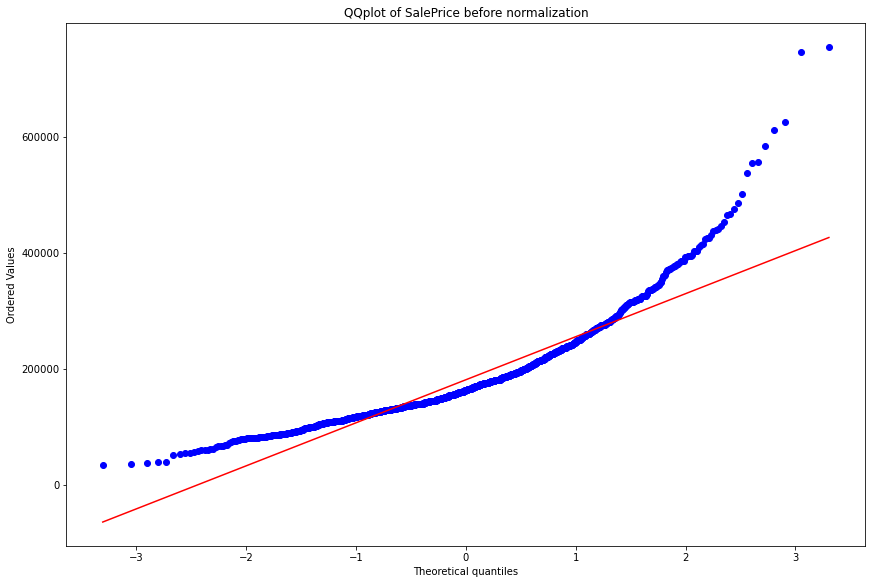

In [37]:
fig = plt.figure(constrained_layout=True, figsize=(8,4))
grid = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

# Plot a QQplot (data before normalization)
ax = fig.add_subplot()
stats.probplot(y, plot=ax)
ax.set_title("QQplot of SalePrice before normalization")

In [38]:
# Normalize the dependent variable (SalePrice)
y = np.log1p(y)

Text(0.5, 1.0, 'QQplot of SalePrice after normalization')

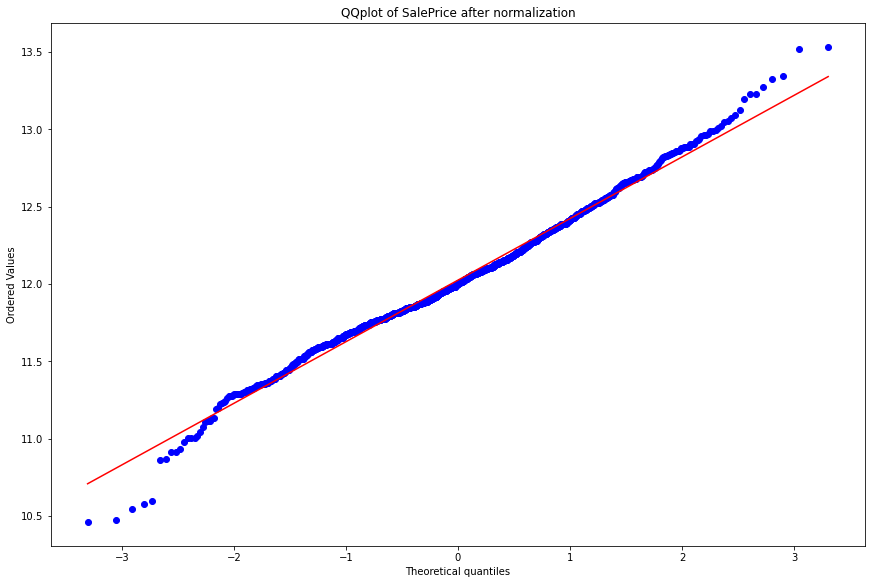

In [40]:
fig = plt.figure(constrained_layout=True, figsize=(8,4))
grid = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

# Plot a QQplot (data after normalization)
ax = fig.add_subplot()
stats.probplot(y, plot=ax)
ax.set_title("QQplot of SalePrice after normalization")

We need to normalize the predictors as well. Since we are going to use linear regression in this notebook, it is a good idea to normalize the predictors.

In [42]:
# Function to normalize the predictors
# This function will be used on the test data as well
def normalize_values(df):
    col_names = list(df)
    min_max_scaler = preprocessing.MinMaxScaler()
    df_scaled = min_max_scaler.fit_transform(df)
    df_norm = pd.DataFrame(df_scaled)
    df_norm.columns = col_names
    return df_norm

In [44]:
X = normalize_values(X)

# 3. Feature Engineering

<h2>3.1 Create Interactions</h2>

In [47]:
# Function to create to two-way interactions for all features
def add_interactions(df, prune=True):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove interaction terms with all 0 values
    if (prune):
        noint_indices = [i for i, x in enumerate(list((df == 0).all())) if x]
        df = df.drop(df.columns[noint_indices], axis=1)
    
    return df

We are not removing any interaction features at this stage (not even the ones with very low values) beacuse we will be performing PCA later.

In [48]:
X = add_interactions(X, False)

In [49]:
print("Shape of training dataset: ", X.shape)

Shape of training dataset:  (1460, 3160)


<h2>3.2 Dimensionality Reduction using PCA</h2>

PCA is a great method for dimensionality reduction. Another good method is feature selection (not shown in this notebook).

In [51]:
pca = PCA(n_components=100)
X_pca = pd.DataFrame(pca.fit_transform(X))

# 4. Model Building

In [53]:
# Use train_test_split  to split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.70, random_state=1)

In [54]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [56]:
y_pred = linreg.predict(X_test)

In [57]:
print("Mean Absolute Error", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Sqaured Error", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Root Mean Squared Logarithmic Error", np.sqrt(metrics.mean_squared_log_error(y_test, y_pred)))

Mean Absolute Error 0.104528800341876
Mean Sqaured Error 0.025564395862070564
Root Mean Squared Error 0.15988869835629585
Root Mean Squared Logarithmic Error 0.012608411963582792


# 5. Predictions on Test Data

In [58]:
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
print("Shape of test dataset: ", test_df.shape)

Shape of test dataset:  (1459, 80)


In [59]:
test_df = test_df.reindex(columns = test_df.columns, fill_value=0)
test_df = create_ordinal_encoding(test_df, cols_to_encode)
test_df = impute_missing_values(test_df)
test_df = remove_ID_col(test_df)
test_df = normalize_values(test_df)
test_df = add_interactions(test_df, False)
test_df_pca = pca.transform(test_df)
print("Shape of test dataset: ", test_df_pca.shape)

Shape of test dataset:  (1459, 100)


In [60]:
# Create submission file
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(linreg.predict(test_df_pca)))
submission.to_csv("submission.csv", index=False)